In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from numpy import sort
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

sns.set()
%matplotlib inline

In [3]:
conn = sqlite3.connect("test_data.db")
cur = conn.cursor()

# Stage 1: Basic SQL Queries


### 1. What was the total revenue to the nearest dollar for customers who have paid by credit card?

SELECT SUM(revenue) FROM customers WHERE cc_payments != 0;

In [4]:
cur.execute("SELECT SUM(revenue) FROM customers WHERE cc_payments != 0;")
results = cur.fetchall()[0][0]
print(f'Total revenue to the nearest dollar for customers who have paid by credit card $ {round(results,2)}')

Total revenue to the nearest dollar for customers who have paid by credit card $ 50372281.74


### 2. What percentage of customers who have purchased female items have paid by credit card?

SELECT COUNT(DISTINCT(customer_id)) FROM customers WHERE (female_items != 0 AND cc_payments != 0)

In [5]:
cur.execute("SELECT COUNT(DISTINCT(customer_id)) FROM customers WHERE (female_items != 0 AND cc_payments != 0)");
cust_purchasing_female_items = cur.fetchall()[0][0]

cur.execute("SELECT COUNT(DISTINCT(customer_id)) FROM customers");
total_cust = cur.fetchall()[0][0]

# print(f"{cust_purchasing_female_items},{total_cust}")
print(f"What percentage of customers who have purchased female items have paid by credit card is {round((cust_purchasing_female_items/total_cust),2)*100}%" )

What percentage of customers who have purchased female items have paid by credit card is 49.0%


### 3. What was the average revenue for customers who used either iOS, Android or Desktop?

SELECT AVG(revenue) FROM customers WHERE(desktop_orders != 0 OR ios_orders !=0 OR android_orders != 0)

In [6]:
cur.execute("SELECT AVG(revenue) FROM customers WHERE(desktop_orders != 0 OR ios_orders !=0 OR android_orders != 0)");
avg_revenue = cur.fetchall()[0][0]
print(f" The average revenue for customers who used either iOS, Android or Desktop = {round(avg_revenue,2)}" )

 The average revenue for customers who used either iOS, Android or Desktop = 1484.89


### 4. We want to run an email campaign promoting a new mens luxury brand. Can you provide a list of customers we should send to?

SELECT customer_id FROM customers WHERE ((male_items != 0 OR unisex_items != 0) AND is_newsletter_subscriber == 'Y')

In [7]:
cur.execute("SELECT customer_id FROM customers WHERE ((male_items != 0 OR unisex_items != 0) AND is_newsletter_subscriber == 'Y')");
customers_interested = cur.fetchall()

print(f" {len(customers_interested)} Customers interested in mens products " )

 9826 Customers interested in mens products 


***

# Stage 2: Cleaning of dataset

CLEAN - Unhash the data (test_data.zip) using the secret key provided by us, extract it, most importantly clean it and put it in a form you can use - all programatically of course. We have also "intentionally" corrupted two columns in this file - two columns that might look correct but are not correct. They need "some correction" to be useful.

### Read JSON data to Dataframe.

In [8]:
df1 = pd.read_json('data.json')
print(f'This data set has {df1.shape[0]} rows & {df1.shape[1]} columns')
df1.shape

This data set has 46279 rows & 43 columns


(46279, 43)

In [9]:
df1.dtypes  # Data types of all features

afterpay_payments             int64
android_orders                int64
apple_payments                int64
average_discount_onoffer    float64
average_discount_used       float64
cancels                       int64
cc_payments                   int64
coupon_discount_applied     float64
curvy_items                   int64
customer_id                  object
days_since_first_order        int64
days_since_last_order         int64
desktop_orders                int64
devices                       int64
different_addresses           int64
female_items                  int64
home_orders                   int64
ios_orders                    int64
is_newsletter_subscriber     object
items                         int64
macc_items                    int64
male_items                    int64
mapp_items                    int64
mftw_items                    int64
msite_orders                  int64
mspt_items                    int64
orders                        int64
other_collection_orders     

In [10]:
df1.describe()

,afterpay_payments,android_orders,apple_payments,average_discount_onoffer,average_discount_used,cancels,cc_payments,coupon_discount_applied,curvy_items,days_since_first_order,...,revenue,sacc_items,shipping_addresses,unisex_items,vouchers,wacc_items,wapp_items,wftw_items,work_orders,wspt_items
count,46279.000000,46279.000000,46279.000000,46279.000000,46279.000000,46279.000000,46279.000000,36074.000000,46279.000000,46279.000000,...,46279.000000,46279.000000,46279.000000,46279.000000,46279.000000,46279.000000,46279.000000,46279.000000,46279.000000,46279.000000
mean,0.053437,0.042935,0.000562,0.190271,2357.381799,0.053091,0.642386,174.395472,0.041423,1374.041444,...,1303.695708,0.087642,1.500940,0.390047,0.940275,0.573565,3.795091,1.633333,0.239785,0.378530
std,0.224905,0.535762,0.023696,0.190814,2033.075229,2.169831,0.479303,838.683487,0.782021,604.972862,...,5599.989015,0.538434,1.098283,1.230722,2.413117,2.538707,12.660505,4.084444,1.560983,1.711348
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,83.883000,0.000000,0.000000,0.000000,0.000000,910.000000,...,76.340000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.150000,2122.648100,0.000000,1.000000,0.000000,0.000000,1713.000000,...,212.670000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.314300,3829.882950,0.000000,1.000000,61.800000,0.000000,1786.000000,...,790.500000,0.000000,2.000000,0.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000
max,1.000000,33.000000,1.000000,1.000000,10000.000000,460.000000,1.000000,33332.260000,116.000000,2164.000000,...,354700.160000,29.000000,15.000000,83.000000,57.000000,353.000000,409.000000,261.000000,84.000000,56.000000


## Validation :  
### Check if there is any Empty/NA entries in the dataset

In [11]:
df1.isnull().values.any()

True

In [12]:
df1.isna().sum()

afterpay_payments               0
android_orders                  0
apple_payments                  0
average_discount_onoffer        0
average_discount_used           0
cancels                         0
cc_payments                     0
coupon_discount_applied     10205
curvy_items                     0
customer_id                     0
days_since_first_order          0
days_since_last_order           0
desktop_orders                  0
devices                         0
different_addresses             0
female_items                    0
home_orders                     0
ios_orders                      0
is_newsletter_subscriber        0
items                           0
macc_items                      0
male_items                      0
mapp_items                      0
mftw_items                      0
msite_orders                    0
mspt_items                      0
orders                          0
other_collection_orders         0
other_device_orders             0
parcelpoint_or

**there are 10205 NA/ Empty values for 'coupon_discount_applied'**  

In [13]:
df1.isna().sum().sum()  #NA found in dataset

10205

In [14]:
df1.isnull().sum().sum()

10205

In [15]:
for c in df1.columns:
    if(len(df1[df1[c].isna()])):
        print(c)

coupon_discount_applied


In [16]:
num_of_items_with_coupon_null = len(df1[df1['coupon_discount_applied'].isnull()])
print(f' {num_of_items_with_coupon_null} customers have NULL/NA coupon discount applied ')

 10205 customers have NULL/NA coupon discount applied 


####  Replace NaN with 0 for all empty 'coupon_discount_applied'

In [17]:
df1['coupon_discount_applied'].fillna(0,inplace=True)  # Fill all NA/NULL with 0

In [18]:
len(df1[df1['coupon_discount_applied'].isnull()])

0

In [19]:
df1.isna().sum().sum() # Should be ZERO by this time.

0

### Validation: Check for Zero standard deviation in column entries.
Zero standard deviation suggests data has some variations and has good spread. ignore features with ZERO std deviation

In [20]:
df1.std()

afterpay_payments               0.224905
android_orders                  0.535762
apple_payments                  0.023696
average_discount_onoffer        0.190814
average_discount_used        2033.075229
cancels                         2.169831
cc_payments                     0.479303
coupon_discount_applied       743.982289
curvy_items                     0.782021
days_since_first_order        604.972862
days_since_last_order       16935.826675
desktop_orders                  6.094596
devices                         0.533424
different_addresses             0.320891
female_items                   17.805349
home_orders                     4.443313
ios_orders                      2.488750
items                          19.932067
macc_items                      2.538707
male_items                      5.464658
mapp_items                      3.693033
mftw_items                      1.441323
msite_orders                    2.855797
mspt_items                      0.715292
orders          

**Great, :+1: all entries has some variations in entires as none of the above has std == 0**  

## Data validation:
**Cancellation which is greater 9 is outlier, so reset cancellation > 9 to 9. we have cancellation of 55,15 & 460 in data** 

In [21]:
df1[df1['cancels']>9]

,afterpay_payments,android_orders,apple_payments,average_discount_onoffer,average_discount_used,cancels,cc_payments,coupon_discount_applied,curvy_items,customer_id,...,revenue,sacc_items,shipping_addresses,unisex_items,vouchers,wacc_items,wapp_items,wftw_items,work_orders,wspt_items
13624,0,0,0,0.1312,2620.3675,15,1,12439.31,0,f90436ed5b0d98ffc000acae4887a749,...,73173.21,1,1,0,14,16,229,6,0,14
16591,0,0,0,0.1929,2711.7172,55,1,299.69,0,d0755a180d3c75b74da9f417686acc70,...,200.75,0,12,2,7,13,13,18,0,3
37682,0,0,0,0.0866,944.6601,460,1,381.67,0,70ffbb7d0356d47ebbd7b2288e16a064,...,4584.76,1,9,83,4,63,192,261,0,6


In [22]:
df1['cancels'] = df1['cancels'].apply(lambda x: 9 if x>9  else x)
df1[df1['cancels']>9]

,afterpay_payments,android_orders,apple_payments,average_discount_onoffer,average_discount_used,cancels,cc_payments,coupon_discount_applied,curvy_items,customer_id,...,revenue,sacc_items,shipping_addresses,unisex_items,vouchers,wacc_items,wapp_items,wftw_items,work_orders,wspt_items


## Data Validation: 
###  Check for " items = male_items + female_items + unisex_items "

In [23]:
len(df1[df1['male_items']+df1['female_items']+df1['unisex_items'] != df1['items']])

0

Great sums match :+1:

**male_items & female_items should be equal to sum of all mXXX_items & wXXX_items respectively**

In [24]:
df1['actual_male_items'] = df1['macc_items']+  df1['mftw_items'] + df1['mapp_items'] + df1['mspt_items']
df1['actual_female_items'] = df1['wacc_items'] +  df1['wftw_items'] + df1['wapp_items'] + df1['wspt_items']

In [25]:
# df1[['male_items','actual_male_items']]
num_mismatch_male_items = len(df1[df1['male_items'] != df1['actual_male_items']])
print(f' Opps {num_mismatch_male_items} of items were wrongly caluculated for male_items' )

 Opps 16882 of items were wrongly caluculated for male_items


In [26]:
num_mismatch_female_items = len(df1[df1['female_items'] != df1['actual_female_items']])
print(f' There is mismatch  of {num_mismatch_female_items} entries for female_items' )

 There is mismatch  of 5834 entries for female_items


## Conversion: Change non-numeric 'customer_id' to numeric cust_num 

In [27]:
le = LabelEncoder()
df1['cust_num'] = le.fit_transform(df1['customer_id'])

In [28]:
df1[['customer_id','cust_num']].head()

,customer_id,cust_num
0,64f7d7dd7a59bba7168cc9c960a5c60e,18249
1,fa7c64efd5c037ff2abcce571f9c1712,45001
2,18923c9361f27583d2320951435e4888,4430
3,aa21f31def4edbdcead818afcdfc4d32,30564
4,668c6aac52ff54d4828ad379cdb38e7d,18547


## Validation: Initial guess of gender based on males_items & female_items

By intuition guessing gender based on mXXX_items for males & wXXX_items for the females

In [29]:
df1['gender'] = 1  # default every one is male

df1.loc[
        (df1['macc_items'] != 0) | 
        (df1['mftw_items'] != 0) |
        (df1['mapp_items'] != 0) |
        (df1['mspt_items'] != 0) |
#         (df1['unisex_items'] != 0) | # Commenting it out, as it should not impact gender.
        (df1['male_items'] != 0),
        'gender'] = 1

df1.loc[
        (df1['wacc_items'] != 0) | 
        (df1['wapp_items'] != 0) |
        (df1['wftw_items'] != 0) |
        (df1['wspt_items'] != 0) |
#         (df1['unisex_items'] != 0) | # Commenting it out, as it should not impact gender.
        (df1['female_items'] != 0)  
        ,
        'gender'] = 0

In [30]:
num_males = len(df1[df1['gender'] == 1])
num_females = len(df1[df1['gender'] == 0])

print(f' We have {num_males} males & {num_females} females in our dataset, as per initial estimate')

 We have 10831 males & 35448 females in our dataset, as per initial estimate


# Stage 3: Build Model#
**BUILD - Build a deep learning model (preferably) or any other model that suitably answers this question and predict the inferred gender using the features provided and deriving more featueres at your end. Remember, there is no gender flag, so you are flying blind here.**

In [31]:
X = df1.iloc[:,0:len(df1.columns)-1]
Y = df1.iloc[:,len(df1.columns)-1]

Drop unnecessary features

In [32]:
X.drop('customer_id',axis=1,inplace=True)
X.drop('male_items',axis=1,inplace=True) # as we have actual_male_items, calculated.
X.drop('female_items',axis=1,inplace=True) # as we have actual_female_items, calculated.

#convert Y/N to 1 & 0
X['is_newsletter_subscriber'] = X['is_newsletter_subscriber'].apply(lambda row: 1 if row == 'Y' else 0)

X.columns #for refernce

Index(['afterpay_payments', 'android_orders', 'apple_payments',
       'average_discount_onoffer', 'average_discount_used', 'cancels',
       'cc_payments', 'coupon_discount_applied', 'curvy_items',
       'days_since_first_order', 'days_since_last_order', 'desktop_orders',
       'devices', 'different_addresses', 'home_orders', 'ios_orders',
       'is_newsletter_subscriber', 'items', 'macc_items', 'mapp_items',
       'mftw_items', 'msite_orders', 'mspt_items', 'orders',
       'other_collection_orders', 'other_device_orders', 'parcelpoint_orders',
       'paypal_payments', 'redpen_discount_used', 'returns', 'revenue',
       'sacc_items', 'shipping_addresses', 'unisex_items', 'vouchers',
       'wacc_items', 'wapp_items', 'wftw_items', 'work_orders', 'wspt_items',
       'actual_male_items', 'actual_female_items', 'cust_num'],
      dtype='object')

Converting 'customer_id' to numerical using LabelEncoder

**Using XGBoost model on training set, get the feature importance**

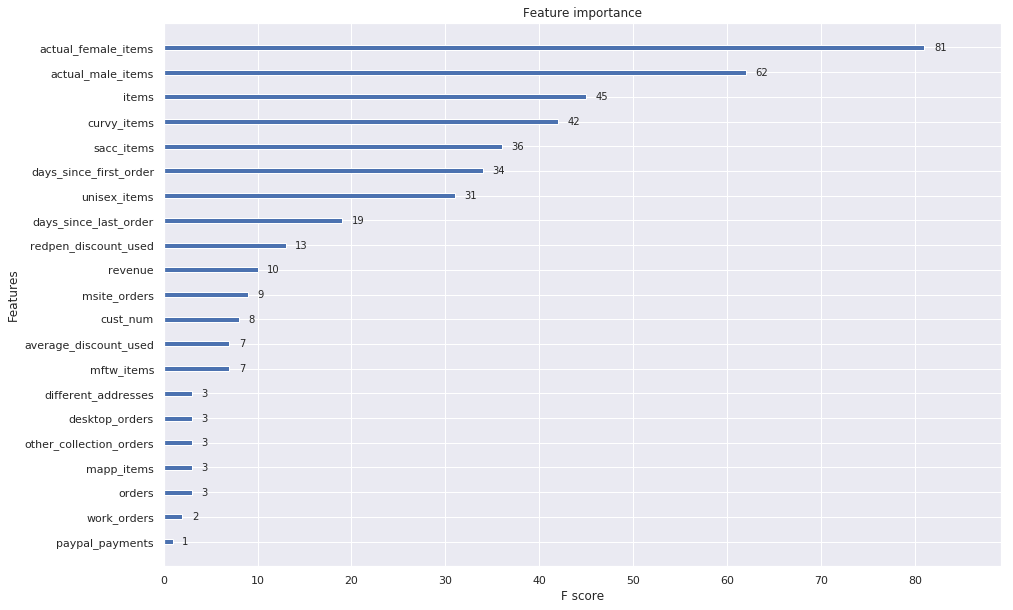

In [33]:
# Split training & test sets.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train)
# print(model)
# print(model.feature_importances_)
# get feature importance from builtin function.
ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(15, 10)
plt.show()

In [34]:
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.42%


### Feature selection & Parameter tunning for XGBoost ###

use 'SelectFromModel',a Meta-transformer for selecting features based on importance weights.

In [35]:
# select features using threshold = 0
selection = SelectFromModel(model, threshold=0, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9841550448503896


Lets try all the thresholds/features & select few features with less impact on accuracy

In [36]:
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
#     predictions = [round(value) for value in y_pred] # no need as has only 0/1 values
    accuracy = accuracy_score(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.000, n=43, Accuracy: 98.42%
Thresh=0.001, n=21, Accuracy: 98.42%
Thresh=0.001, n=20, Accuracy: 98.40%
Thresh=0.002, n=19, Accuracy: 98.42%
Thresh=0.002, n=18, Accuracy: 98.44%
Thresh=0.002, n=17, Accuracy: 98.43%
T

Selecting Threshold of 0.005, at when num of features selected is 10 (n=10), since it has the highest accuracy of 98.47%

In [37]:
# select features using threshold
selection = SelectFromModel(model, threshold=0.005, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.984744320041904


Lets see the confusion matrix to validate the model

In [38]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[11523,   196],
       [   37,  3517]])

In [39]:
select_X = selection.transform(X)
predicted_gender = selection_model.predict(select_X)
X['predicted_gender'] = predicted_gender

**We had 10831 males & 35448 females in our dataset, as per our initial estimate before**

In [40]:
num_males_new = len(X[X['predicted_gender'] == 1])
num_females_new = len(X[X['predicted_gender'] == 0])

print(f' Now I have {num_males_new} males & {num_females_new} females in our dataset, as per the Model')
print(f' {num_males_new-num_males} Genders got corrected')

 Now I have 11339 males & 34940 females in our dataset, as per the Model
 508 Genders got corrected


*** 

# Stage 4: Reporting & Visualization

## Impact of males & females on Revenue & Orders.

In [41]:
order_revenue_tbl = X.pivot_table(
                                index=['predicted_gender'],
                                values=['revenue','orders'],
                                aggfunc=[np.sum,np.mean]
                                )
order_revenue_tbl

sum                    mean             
                  orders       revenue    orders      revenue
predicted_gender                                             
0                 167326  5.509044e+07  4.788952  1576.715623
1                  22798  5.243290e+06  2.010583   462.412014

_From above table its evident that we get most of the revenue & orders from females(0) than males(1)_

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1ec47a2668>,
      dtype=object)

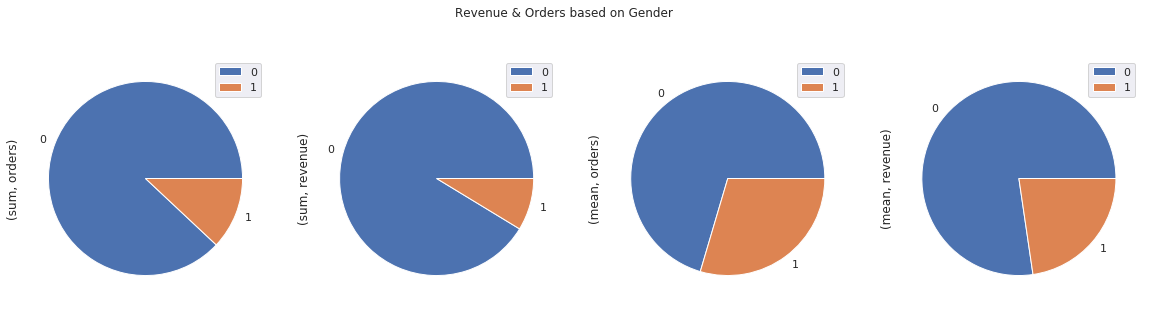

In [42]:
order_revenue_tbl.plot(kind='pie',subplots=True,figsize=(20,5),title="Revenue & Orders based on Gender")

In [43]:
returns_tbl = X.pivot_table(index=['predicted_gender'],
              values=['returns','orders'],
              aggfunc=np.mean)

returns_tbl

,orders,returns
predicted_gender,,
0,4.788952,2.050773
1,2.010583,0.302055


## Number of "return" orders based on gender. 

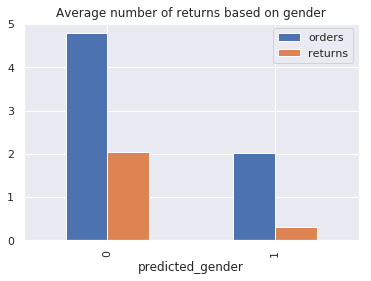

In [44]:
returns_tbl.plot(kind='bar',title='Average number of returns based on gender')

In [45]:
percentage_male_returns = X[X['predicted_gender'] == 1]['returns'].sum() / X[X['predicted_gender'] == 1]['orders'].sum()
print(f'Only {round(percentage_male_returns*100,2)}% of orders are returned by gentle mens :-)')

Only 15.02% of orders are returned by gentle mens :-)


In [46]:
percentage_female_returns = X[X['predicted_gender'] == 0]['returns'].sum() / X[X['predicted_gender'] == 0]['orders'].sum()
print(f'{round(percentage_female_returns*100,2)}% of orders are returned by ladies')

42.82% of orders are returned by ladies


## Items purchased by both the genders

In [47]:
items_tbl = X.pivot_table(index=['predicted_gender'],
                          values=['macc_items','mapp_items','mftw_items','mspt_items',\
                                   'wacc_items','wapp_items', 'wftw_items','wspt_items','unisex_items'],
                          aggfunc=np.sum)

items_tbl

,macc_items,mapp_items,mftw_items,mspt_items,unisex_items,wacc_items,wapp_items,wftw_items,wspt_items
predicted_gender,,,,,,,,,
0,26544,21573,9928,2997,13353,26544,175633,75589,17518
1,0,21332,9515,2369,4698,0,0,0,0


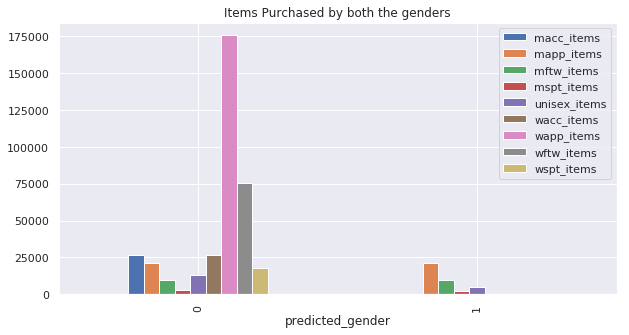

In [48]:
items_tbl.plot(kind='bar',title='Items Purchased by both the genders',figsize=(10,5))

Women's have significant impact on men's items, so **marketing stragegy** for men's items should attract women as well.<br> 
Women's Apparel are the top selling item.

## Items purchased on devices catagorized by gender

In [49]:
items_devices_tbl = X.pivot_table(index=['predicted_gender'],
                                  values=['msite_orders','other_device_orders','ios_orders','android_orders','desktop_orders',
                                  'devices'],
                                  aggfunc=np.mean)

items_devices_tbl

,android_orders,desktop_orders,devices,ios_orders,msite_orders,other_device_orders
predicted_gender,,,,,,
0,0.049199,3.001631,1.333915,0.568546,1.169519,0.000057
1,0.023635,1.460975,1.103536,0.137578,0.388394,0.000000


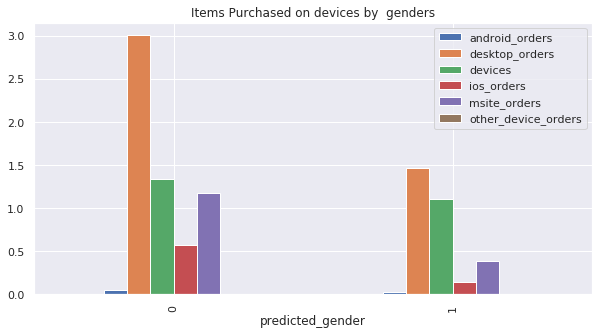

In [50]:
items_devices_tbl.plot(kind='bar',title='Items Purchased on devices by  genders',figsize=(10,5))

1) Desktop is the preferred way to purchase, so concentrate Ads on desktops. <br>
2) And Ios/Apple devices are popular in this area. <br>
3) As orders from mobile site is more, either encourage customers to use mobile apps by having more offers on mobile apps OR enhance to mobile App to attract customers, as they might be forced to use mobile sites.<br>
***

## Active users & locations

In [51]:
active_users_tbl = X.pivot_table(index=['predicted_gender'],
                          values=['days_since_last_order','days_since_first_order'],
                          aggfunc=np.mean)

active_users_tbl

,days_since_first_order,days_since_last_order
predicted_gender,,
0,1381.229994,23153.585804
1,1351.890643,29027.086692


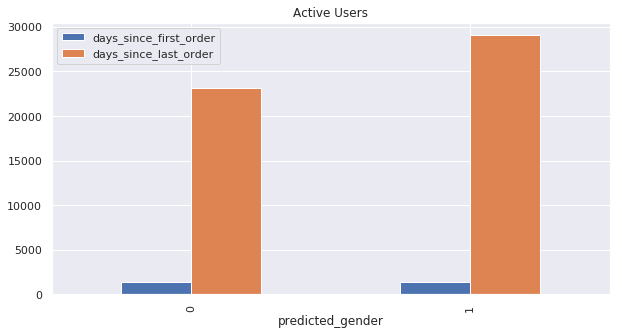

In [52]:
active_users_tbl.plot(kind='bar',title='Active Users',figsize=(10,5))

Females are more active in shopping than men, as they have less average days_since_last_order

## Prefered locations by users based on gender

In [53]:
users_location_tbl = X.pivot_table(index=['predicted_gender'],
                          values=['work_orders','home_orders','parcelpoint_orders','other_collection_orders'],
                          aggfunc=np.sum)

users_location_tbl

,home_orders,other_collection_orders,parcelpoint_orders,work_orders
predicted_gender,,,,
0,64439,91874,1023,9990
1,6469,15075,147,1107


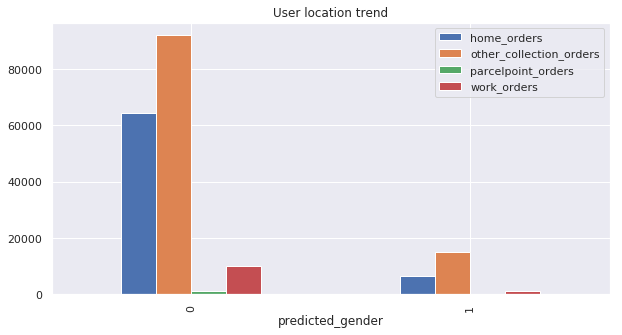

In [54]:
users_location_tbl.plot(kind='bar',title='User location trend',figsize=(10,5))

- Both the gender prefer orders to be delivered to the "other collection points" followed by "home". <br>
- **INSIGHT: females order more gifts, for non-work collegues**. since number of orders shipped to other collection points is greater than home orders <br>
- The site offers more gift items or used data was collection during festive season (Thanksgiving ,etc) 

## Prefered payment by gender

In [55]:
prefered_payments_tbl = X.pivot_table(index=['predicted_gender'],
                          values=['cc_payments','paypal_payments','apple_payments','afterpay_payments'],
                          aggfunc=np.sum)

prefered_payments_tbl

,afterpay_payments,apple_payments,cc_payments,paypal_payments
predicted_gender,,,,
0,2186,19,22938,17645
1,287,7,6791,5074


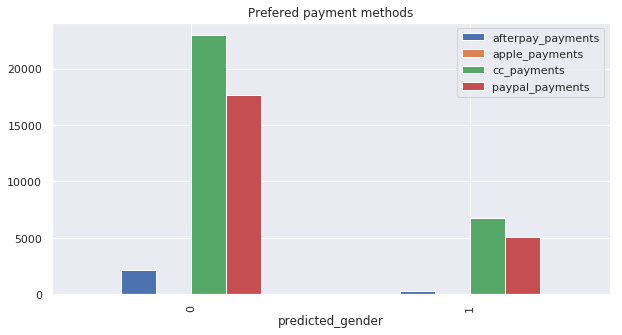

In [56]:
prefered_payments_tbl.plot(kind='bar',title='Prefered payment methods',figsize=(10,5))

Apple payment is not popular at the moment, even though most of the users use ios devices, <br> Credit card is prefered first followed by paypal

## Subscribers distribution

In [57]:
subcribers_tbl = X.pivot_table(index=['predicted_gender'],
                          values=['is_newsletter_subscriber'],
                          aggfunc=np.sum)

subcribers_tbl

,is_newsletter_subscriber
predicted_gender,
0,15443
1,3462


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1ec4ae4048>],
      dtype=object)

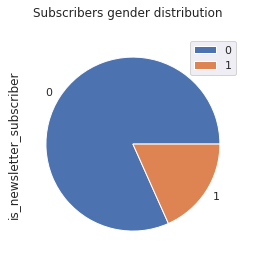

In [58]:
subcribers_tbl.plot(kind='pie',title='Subscribers gender distribution',subplots=True)

We have more female subscribers than males

## Discounts used by genders

In [59]:
discounts_tbl = X.pivot_table(index=['predicted_gender'],
                          values=['average_discount_used'],
                          aggfunc=np.mean)

discounts_tbl

,average_discount_used
predicted_gender,
0,2415.209501
1,2179.191489


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1ec4b10d30>],
      dtype=object)

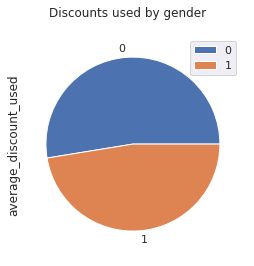

In [60]:
discounts_tbl.plot(kind='pie',title='Discounts used by gender',subplots=True)

Discounts are utilized equally by both the genders

## Average total Items purchased by gender

In [61]:
avg_items_purchased = X.pivot_table(index=['predicted_gender'],
                          values=['items'],
                          aggfunc=np.mean)

avg_items_purchased

,items
predicted_gender,
0,10.117086
1,3.823529


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1ec4b89cc0>],
      dtype=object)

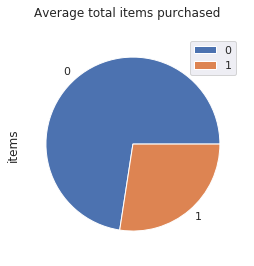

In [62]:
avg_items_purchased.plot(kind='pie',title='Average total items purchased',subplots=True)

On average, females have purchased more items than males. 

## Items preferences by gender

In [63]:
item_pref_tbl = X.pivot_table(index=['predicted_gender'],
                          values=['actual_female_items','actual_male_items'],
                          aggfunc=np.mean)

item_pref_tbl

,actual_female_items,actual_male_items
predicted_gender,,
0,8.451173,1.747052
1,0.000000,2.929359


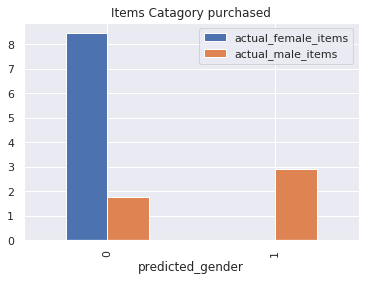

In [64]:
item_pref_tbl.plot(kind='bar',title='Items Catagory purchased')

<font color=blue>

**Observation:** Females purchase men's collection for gifting purposes :-), but men does not purchase gifts for women's items :(. <br>

</font>


***